# Bayesian biodiversity: Model evaluation

In [13]:
import numpy as np
import dill
import arviz as az
import xarray as xr
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [316]:
# Load black for formatting
import jupyter_black

jupyter_black.load()

In [317]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="arviz")

## Read outputs from model training and format data

In [55]:
# Load the model output dictionary and extract all variables
output_path = "../../data/runs/run_folder_2024-03-22_20.42/model_output.pkl"

with open(output_path, "rb") as in_stream:
    model_output = dill.load(in_stream)

model = model_output["model"]
trace = model_output["trace"]
pymc_var_names = model_output["pymc_var_names"]

group_mapping = {code: name for name, code in model_output["group_mapping"].items()}
group_idx = model_output["group_idx"]
covariates = model_output["covariates"]
variable_mapping = {code: var for code, var in enumerate(covariates)}

y_true = model_output["y_true"]
y_pred = model_output["y_pred"]

print(pymc_var_names)

['mu_beta', 'sigma_beta', 'beta']


In [56]:
# Update the coordinates of beta_dim_0 and beta_dim_1
trace.posterior = trace.posterior.assign_coords(
    beta_dim_0=[group_mapping[idx] for idx in trace.posterior.beta_dim_0.values],
    beta_dim_1=[variable_mapping[idx] for idx in trace.posterior.beta_dim_1.values],
)

KeyError: 12

In [45]:
def filter_trace_by_group(var_name, group_name, group_mapping):

    for code, name in group_mapping.items():
        if group_name == name:
            group_index = code

    # Filter the 'beta' variable for the selected group
    beta_filtered = trace.posterior[var_name].isel(beta_dim_0=group_index)
    filtered_ds = xr.Dataset({var_name: beta_filtered})
    filtered_trace = az.InferenceData(posterior=filtered_ds)

    return filtered_trace

In [358]:
trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

## Model goodness of fit

In [46]:
def plot_actual_pred(y_true, y_pred, group=None):
    r2 = r2_score(y_true, y_pred)

    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.xlabel("Observed")
    plt.ylabel("Predicted")
    plt.title("All groups: Observed vs predicted abundance")

    plt.plot(
        [min(y_true), max(y_true)],
        [min(y_true), max(y_true)],
        color="red",
        linestyle="--",
        linewidth=2,
    )
    plt.text(0.05, 0.95, f"R² = {r2:.3f}", fontsize=12, transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

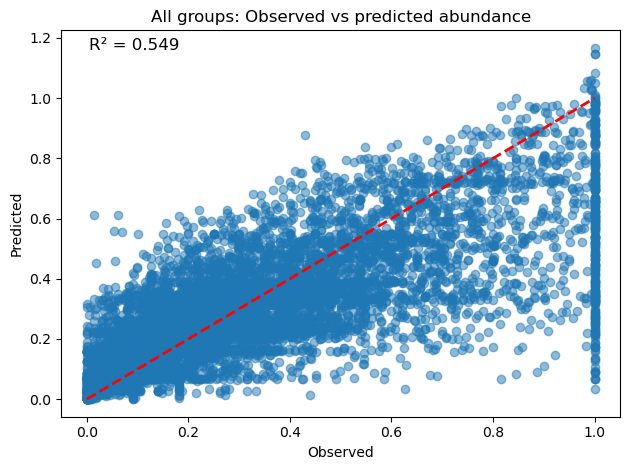

In [57]:
plot_actual_pred(y_true, y_pred)

In [36]:
def plot_actual_pred_by_group(y_true, y_pred, group_idx, group_mapping):
    # Determine the number of unique groups
    groups = np.unique(group_idx)
    n_groups = len(groups)

    # Calculate the dimensions of the grid of subplots (simple square root rule used here)
    n_cols = int(np.ceil(np.sqrt(n_groups)))
    n_rows = int(np.ceil(n_groups / n_cols))

    # Set the figsize dynamically based on the number of groups (arbitrary width and height per subplot)
    fig, axs = plt.subplots(
        n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), constrained_layout=True
    )

    # Flatten the axs array for easy iteration
    axs = axs.ravel()

    for idx, group in enumerate(groups):
        # Select the data for the current group
        mask = group_idx == group
        y_true_group = y_true[mask]
        y_pred_group = y_pred[mask]

        # Calculate the R^2 score for the current group
        r2 = r2_score(y_true_group, y_pred_group)

        # Plot the actual vs predicted values for the current group
        axs[idx].scatter(y_true_group, y_pred_group, alpha=0.5)

        # Add the perfect fit line
        min_val, max_val = min(y_true_group), max(y_true_group)
        axs[idx].plot([min_val, max_val], [min_val, max_val], "r--", linewidth=2)

        # Add the R^2 score text
        axs[idx].text(
            0.05, 0.9, f"R² = {r2:.2f}", fontsize=12, transform=axs[idx].transAxes
        )

        # Set labels and title
        axs[idx].set_xlabel("Observed")
        axs[idx].set_ylabel("Predicted")
        axs[idx].set_title(f"{group_mapping.get(group, group)}")

        # Ensure the subplot axes do not overlap
        axs[idx].tick_params(axis="x", labelrotation=45)

    # Hide any empty subplots that aren't used (if the number of groups is not a perfect square)
    for ax in axs[n_groups:]:
        ax.set_visible(False)

    plt.show()

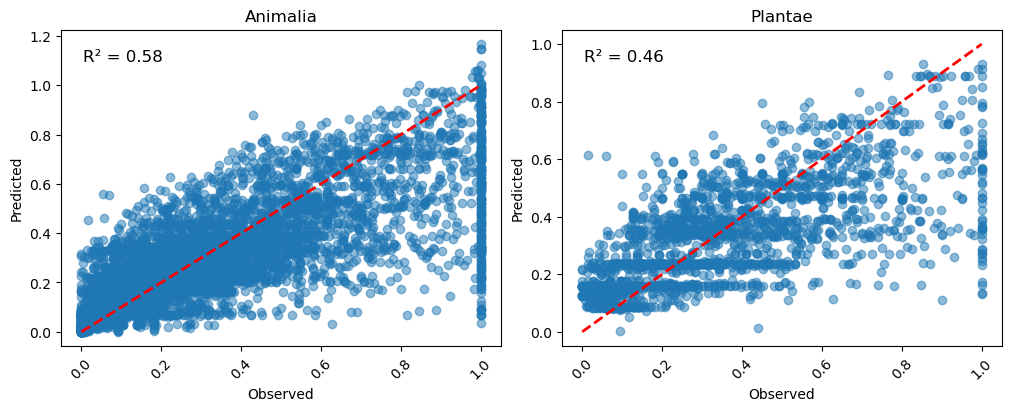

In [58]:
plot_actual_pred_by_group(y_true, y_pred, group_idx, group_mapping)

## Posterior predictive distribution

/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())
/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(

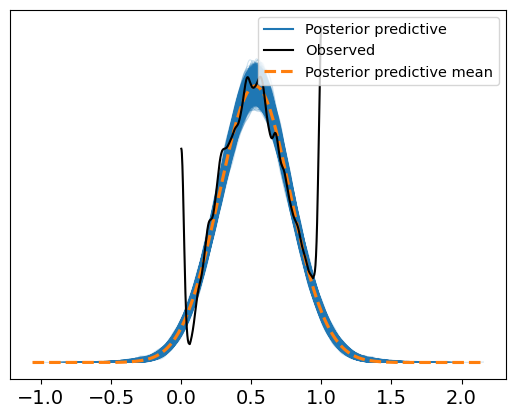

In [59]:
az.plot_ppc(trace)
for label in ax.get_xticklabels():
    label.set_fontsize(10)
plt.xlabel("")
ax.legend(fontsize=10)
plt.show()

## Posterior summary results

### Hyperprior posteriors

In [39]:
# Summary output for posteror of hyperprior
az.summary(trace, var_names=["mu_beta"], round_to=2)

mean    sd  hdi_3%  hdi_97%  \
mu_beta[Primary vegetation_Light use]     -0.05  0.33   -0.72     0.63   
mu_beta[Primary vegetation_Intense use]   -0.02  0.23   -0.51     0.48   
mu_beta[Secondary vegetation_Minimal use] -0.04  0.19   -0.48     0.35   
mu_beta[Secondary vegetation_Light use]   -0.00  0.20   -0.45     0.38   
mu_beta[Secondary vegetation_Intense use] -0.04  0.25   -0.55     0.51   
mu_beta[Cropland_Minimal use]             -0.03  0.32   -0.68     0.58   
mu_beta[Cropland_Light_Intense]           -0.03  0.55   -1.15     1.10   
mu_beta[Pasture_Minimal use]               0.05  0.35   -0.64     0.77   
mu_beta[Pasture_Light_Intense]            -0.08  0.25   -0.66     0.34   
mu_beta[Urban_All uses]                   -0.06  0.40   -0.81     0.78   
mu_beta[Pop_density_1km_log]              -0.01  0.20   -0.33     0.44   
mu_beta[Road_density_50km_cbrt]            0.03  0.25   -0.49     0.51   

                                           mcse_mean  mcse_sd  ess_bulk  \
mu_beta[Primary vegetation_Light use]           0.02     0.01    451.73   
mu_beta[Primary vegetation_Intense use]         0.02     0.01    195.28   
mu_beta[Secondary vegetation_Minimal use]       0.01     0.01    415.68   
mu_beta[Secondary vegetation_Light use]         0.01     0.01    274.36   
mu_beta[Secondary vegetation_Intense use]       0.01     0.01    392.65   
mu_beta[Cropland_Minimal use]                   0.02     0.01    431.35   
mu_beta[Cropland_Light_Intense]                 0.02     0.02    514.15   
mu_beta[Pasture_Minimal use]                    0.02     0.02    293.34   
mu_beta[Pasture_Light_Intense]                  0.01     0.01    307.39   
mu_beta[Urban_All uses]                         0.02     0.01    502.05   
mu_beta[Pop_density_1km_log]                    0.01     0.01    644.22   
mu_beta[Road_density_50km_cbrt]                 0.01     0.01    512.93   

                                           ess_tail  r_hat  
mu_beta[Primary vegetation_Light use]        774.81   1.01  
mu_beta[Primary vegetation_Intense use]      227.01   1.02  
mu_beta[Secondary vegetation_Minimal use]    498.70   1.02  
mu_beta[Secondary vegetation_Light use]      425.27   1.01  
mu_beta[Secondary vegetation_Intense use]    400.77   1.01  
mu_beta[Cropland_Minimal use]                394.32   1.02  
mu_beta[Cropland_Light_Intense]              872.51   1.02  
mu_beta[Pasture_Minimal use]                 277.59   1.02  
mu_beta[Pasture_Light_Intense]               364.60   1.01  
mu_beta[Urban_All uses]                      682.05   1.01  
mu_beta[Pop_density_1km_log]                 853.57   1.01  
mu_beta[Road_density_50km_cbrt]              682.72   1.01

### Group-level posteriors

In [50]:
# Summary output for group-level posteriors
group = "Animalia"
group_trace = filter_trace_by_group(
    var_name="beta", group_name=group, group_mapping=group_mapping
)
az.summary(group_trace, var_names=["beta"], round_to=2)

mean    sd  hdi_3%  hdi_97%  \
beta[Intercept]                         0.05  0.01    0.02     0.07   
beta[Primary vegetation_Light use]     -0.00  0.02   -0.04     0.04   
beta[Primary vegetation_Intense use]   -0.03  0.01   -0.05    -0.01   
beta[Secondary vegetation_Minimal use] -0.00  0.01   -0.02     0.02   
beta[Secondary vegetation_Light use]   -0.05  0.01   -0.07    -0.03   
beta[Secondary vegetation_Intense use]  0.04  0.02    0.00     0.07   
beta[Cropland_Minimal use]             -0.05  0.02   -0.09    -0.01   
beta[Cropland_Light_Intense]           -0.05  0.02   -0.09    -0.01   
beta[Pasture_Minimal use]              -0.08  0.02   -0.12    -0.05   
beta[Pasture_Light_Intense]             0.05  0.03   -0.02     0.11   
beta[Urban_All uses]                   -0.01  0.01   -0.02     0.01   
beta[Pop_density_1km_log]               0.01  0.03   -0.04     0.05   

                                        mcse_mean  mcse_sd  ess_bulk  \
beta[Intercept]                               0.0      0.0   5147.52   
beta[Primary vegetation_Light use]            0.0      0.0   8642.65   
beta[Primary vegetation_Intense use]          0.0      0.0  10330.97   
beta[Secondary vegetation_Minimal use]        0.0      0.0   9028.33   
beta[Secondary vegetation_Light use]          0.0      0.0   7412.43   
beta[Secondary vegetation_Intense use]        0.0      0.0  13559.50   
beta[Cropland_Minimal use]                    0.0      0.0  14203.53   
beta[Cropland_Light_Intense]                  0.0      0.0  12060.93   
beta[Pasture_Minimal use]                     0.0      0.0   7631.67   
beta[Pasture_Light_Intense]                   0.0      0.0  18620.78   
beta[Urban_All uses]                          0.0      0.0   7170.26   
beta[Pop_density_1km_log]                     0.0      0.0   3914.01   

                                        ess_tail  r_hat  
beta[Intercept]                         11633.70    1.0  
beta[Primary vegetation_Light use]      16025.54    1.0  
beta[Primary vegetation_Intense use]    16191.04    1.0  
beta[Secondary vegetation_Minimal use]  15233.77    1.0  
beta[Secondary vegetation_Light use]    12389.14    1.0  
beta[Secondary vegetation_Intense use]  17766.43    1.0  
beta[Cropland_Minimal use]              17547.42    1.0  
beta[Cropland_Light_Intense]            17237.04    1.0  
beta[Pasture_Minimal use]               14408.65    1.0  
beta[Pasture_Light_Intense]             17382.46    1.0  
beta[Urban_All uses]                    13784.15    1.0  
beta[Pop_density_1km_log]                8083.47    1.0

## Posterior distributions and parameter intervals

### Group-level forest plots

In [52]:
def forest_plot(trace, var_names):

    axes = az.plot_forest(
        data=trace,
        var_names=var_names,
        combined=True,
        hdi_prob=0.95,
    )

    ax = axes[0]
    labels = [item.get_text() for item in ax.get_yticklabels()]
    new_labels = []
    for label in labels:
        new_label = (
            label.replace("[", "")
            .replace("]", "")
            .replace(",", ":")
            .replace(var_names[0], "")
        )
        new_labels.append(new_label)

    for label in ax.get_yticklabels():
        label.set_fontsize(10)
    for label in ax.get_xticklabels():
        label.set_fontsize(10)

    # Set the new labels to the y-axis
    ax.set_yticklabels(new_labels)

    plt.tight_layout()
    plt.show()

In [51]:
forest_plot(trace, var_names=["beta"])

NameError: name 'forest_plot' is not defined

### Hyperprior posterior distributions

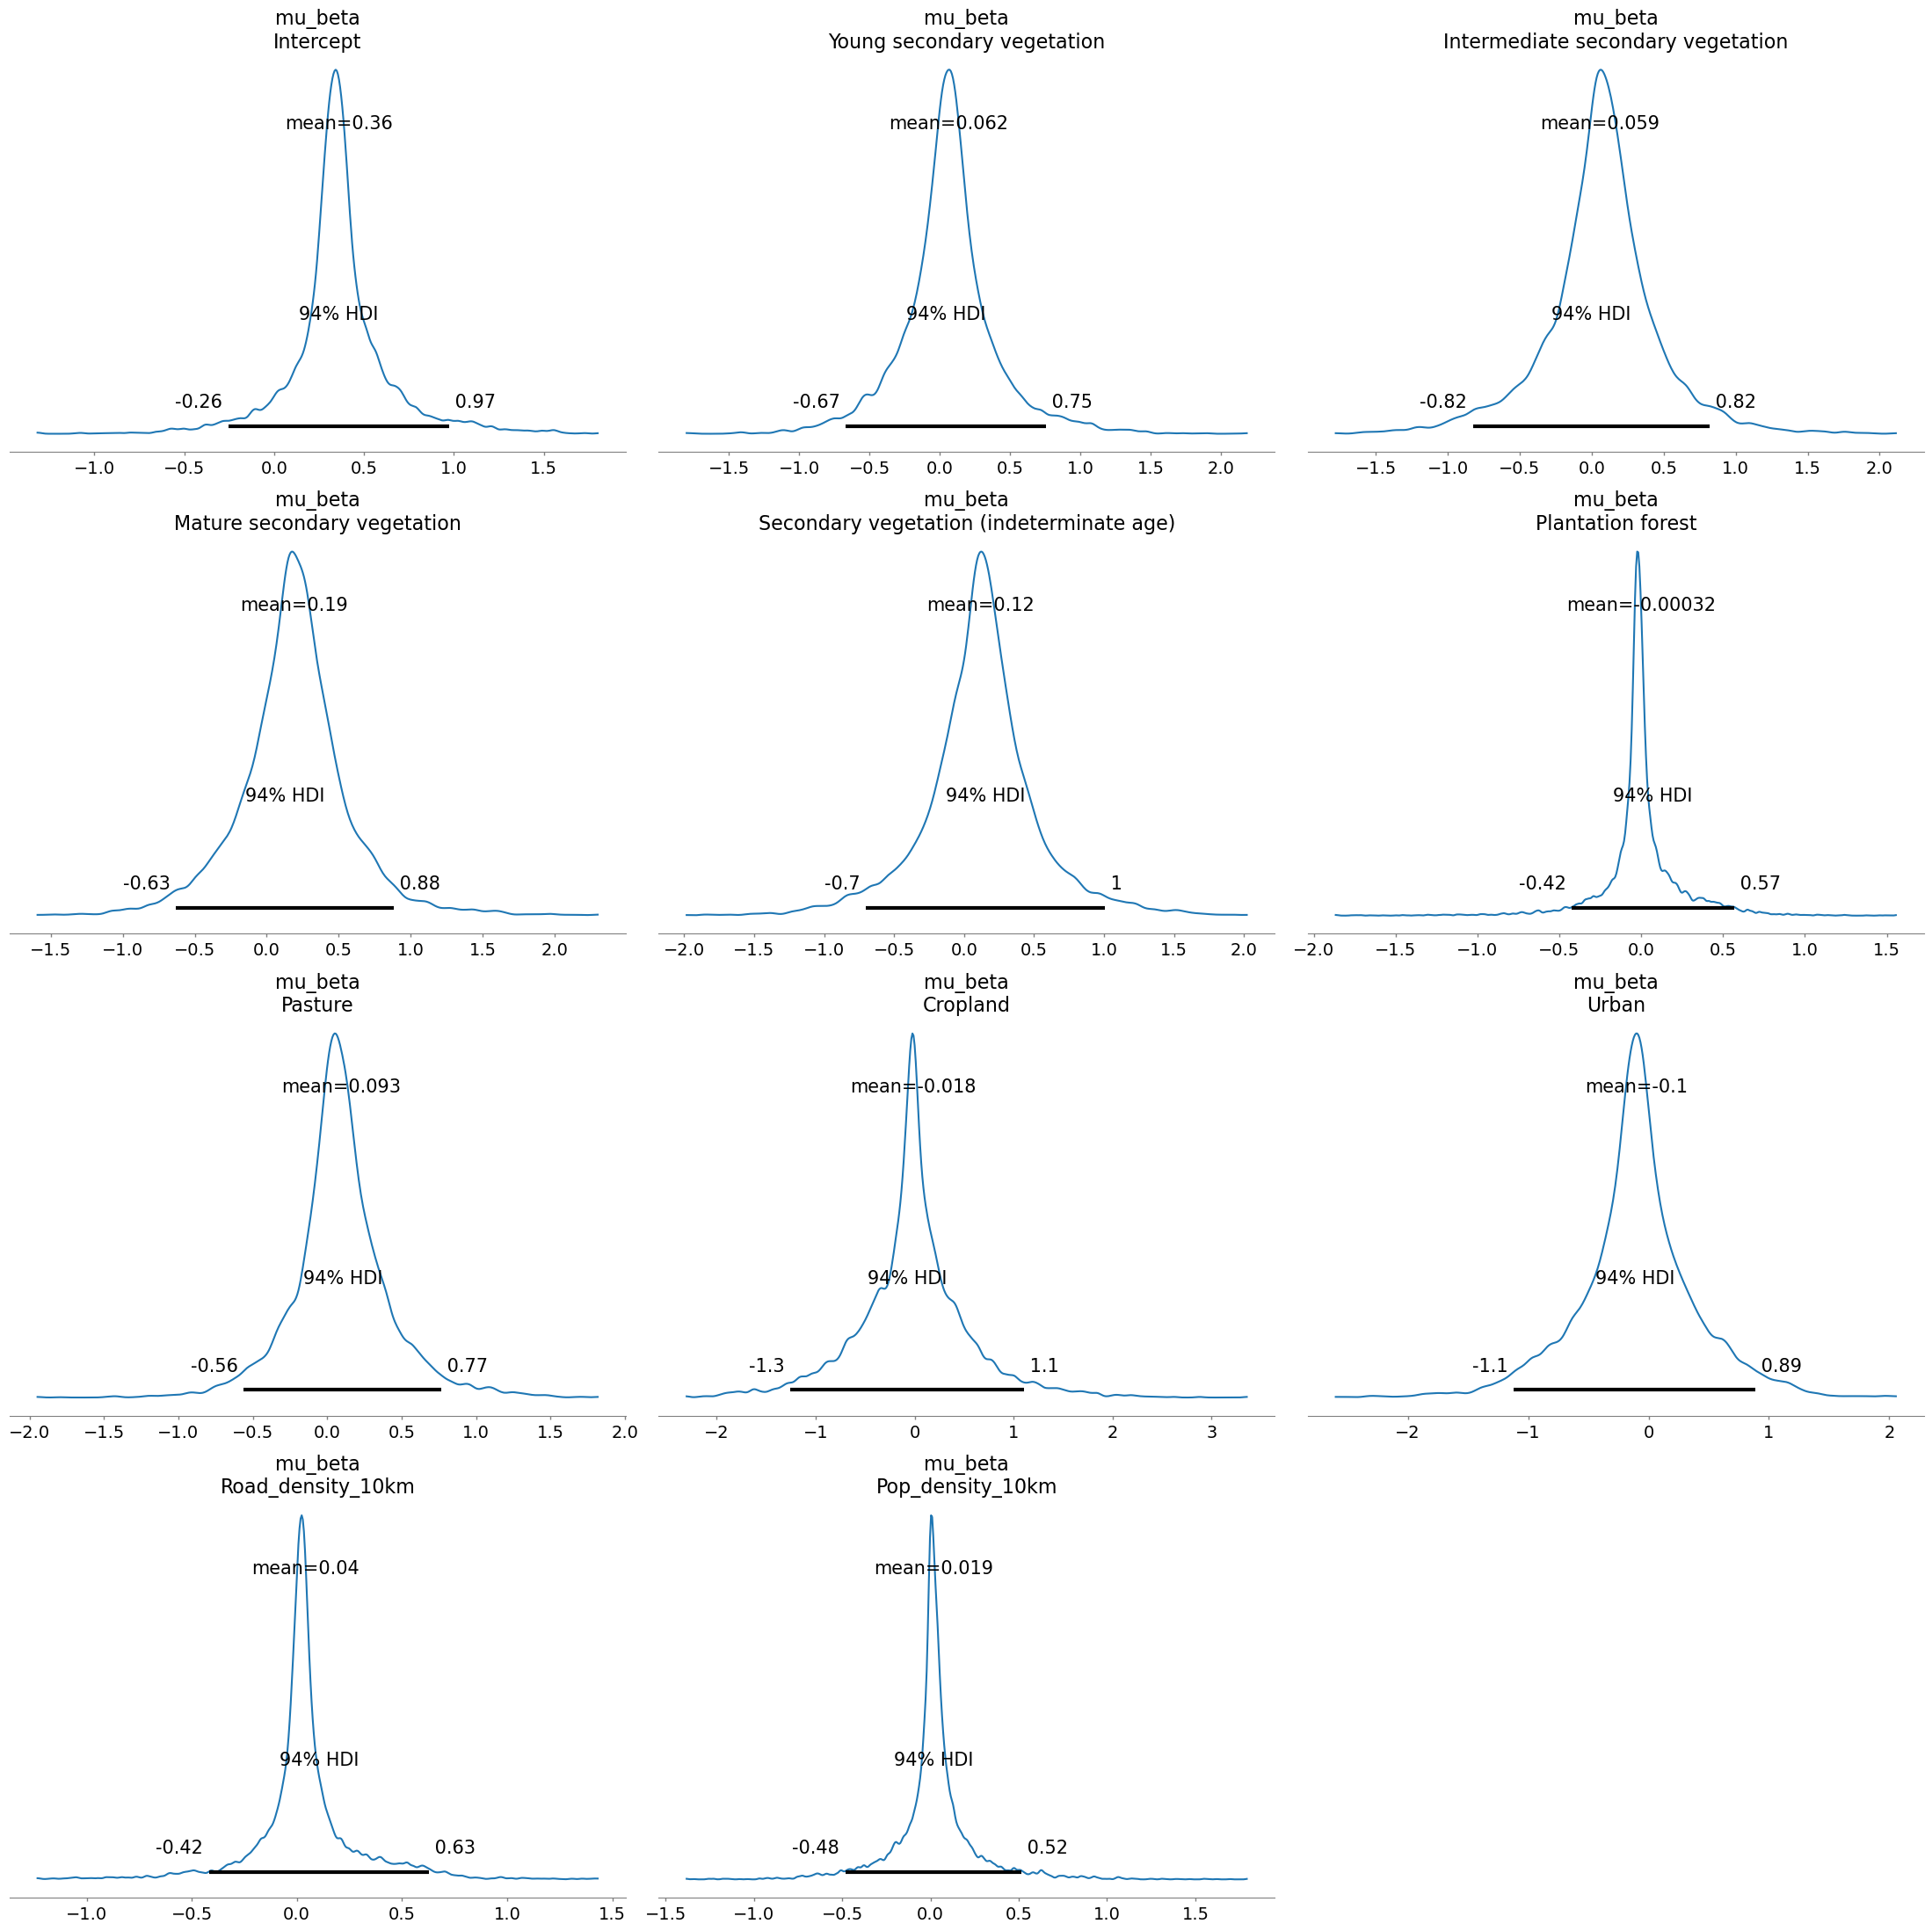

In [29]:
az.plot_posterior(trace, var_names=["mu_beta"])
plt.tight_layout()
plt.show()

### Group-level posterior distributions

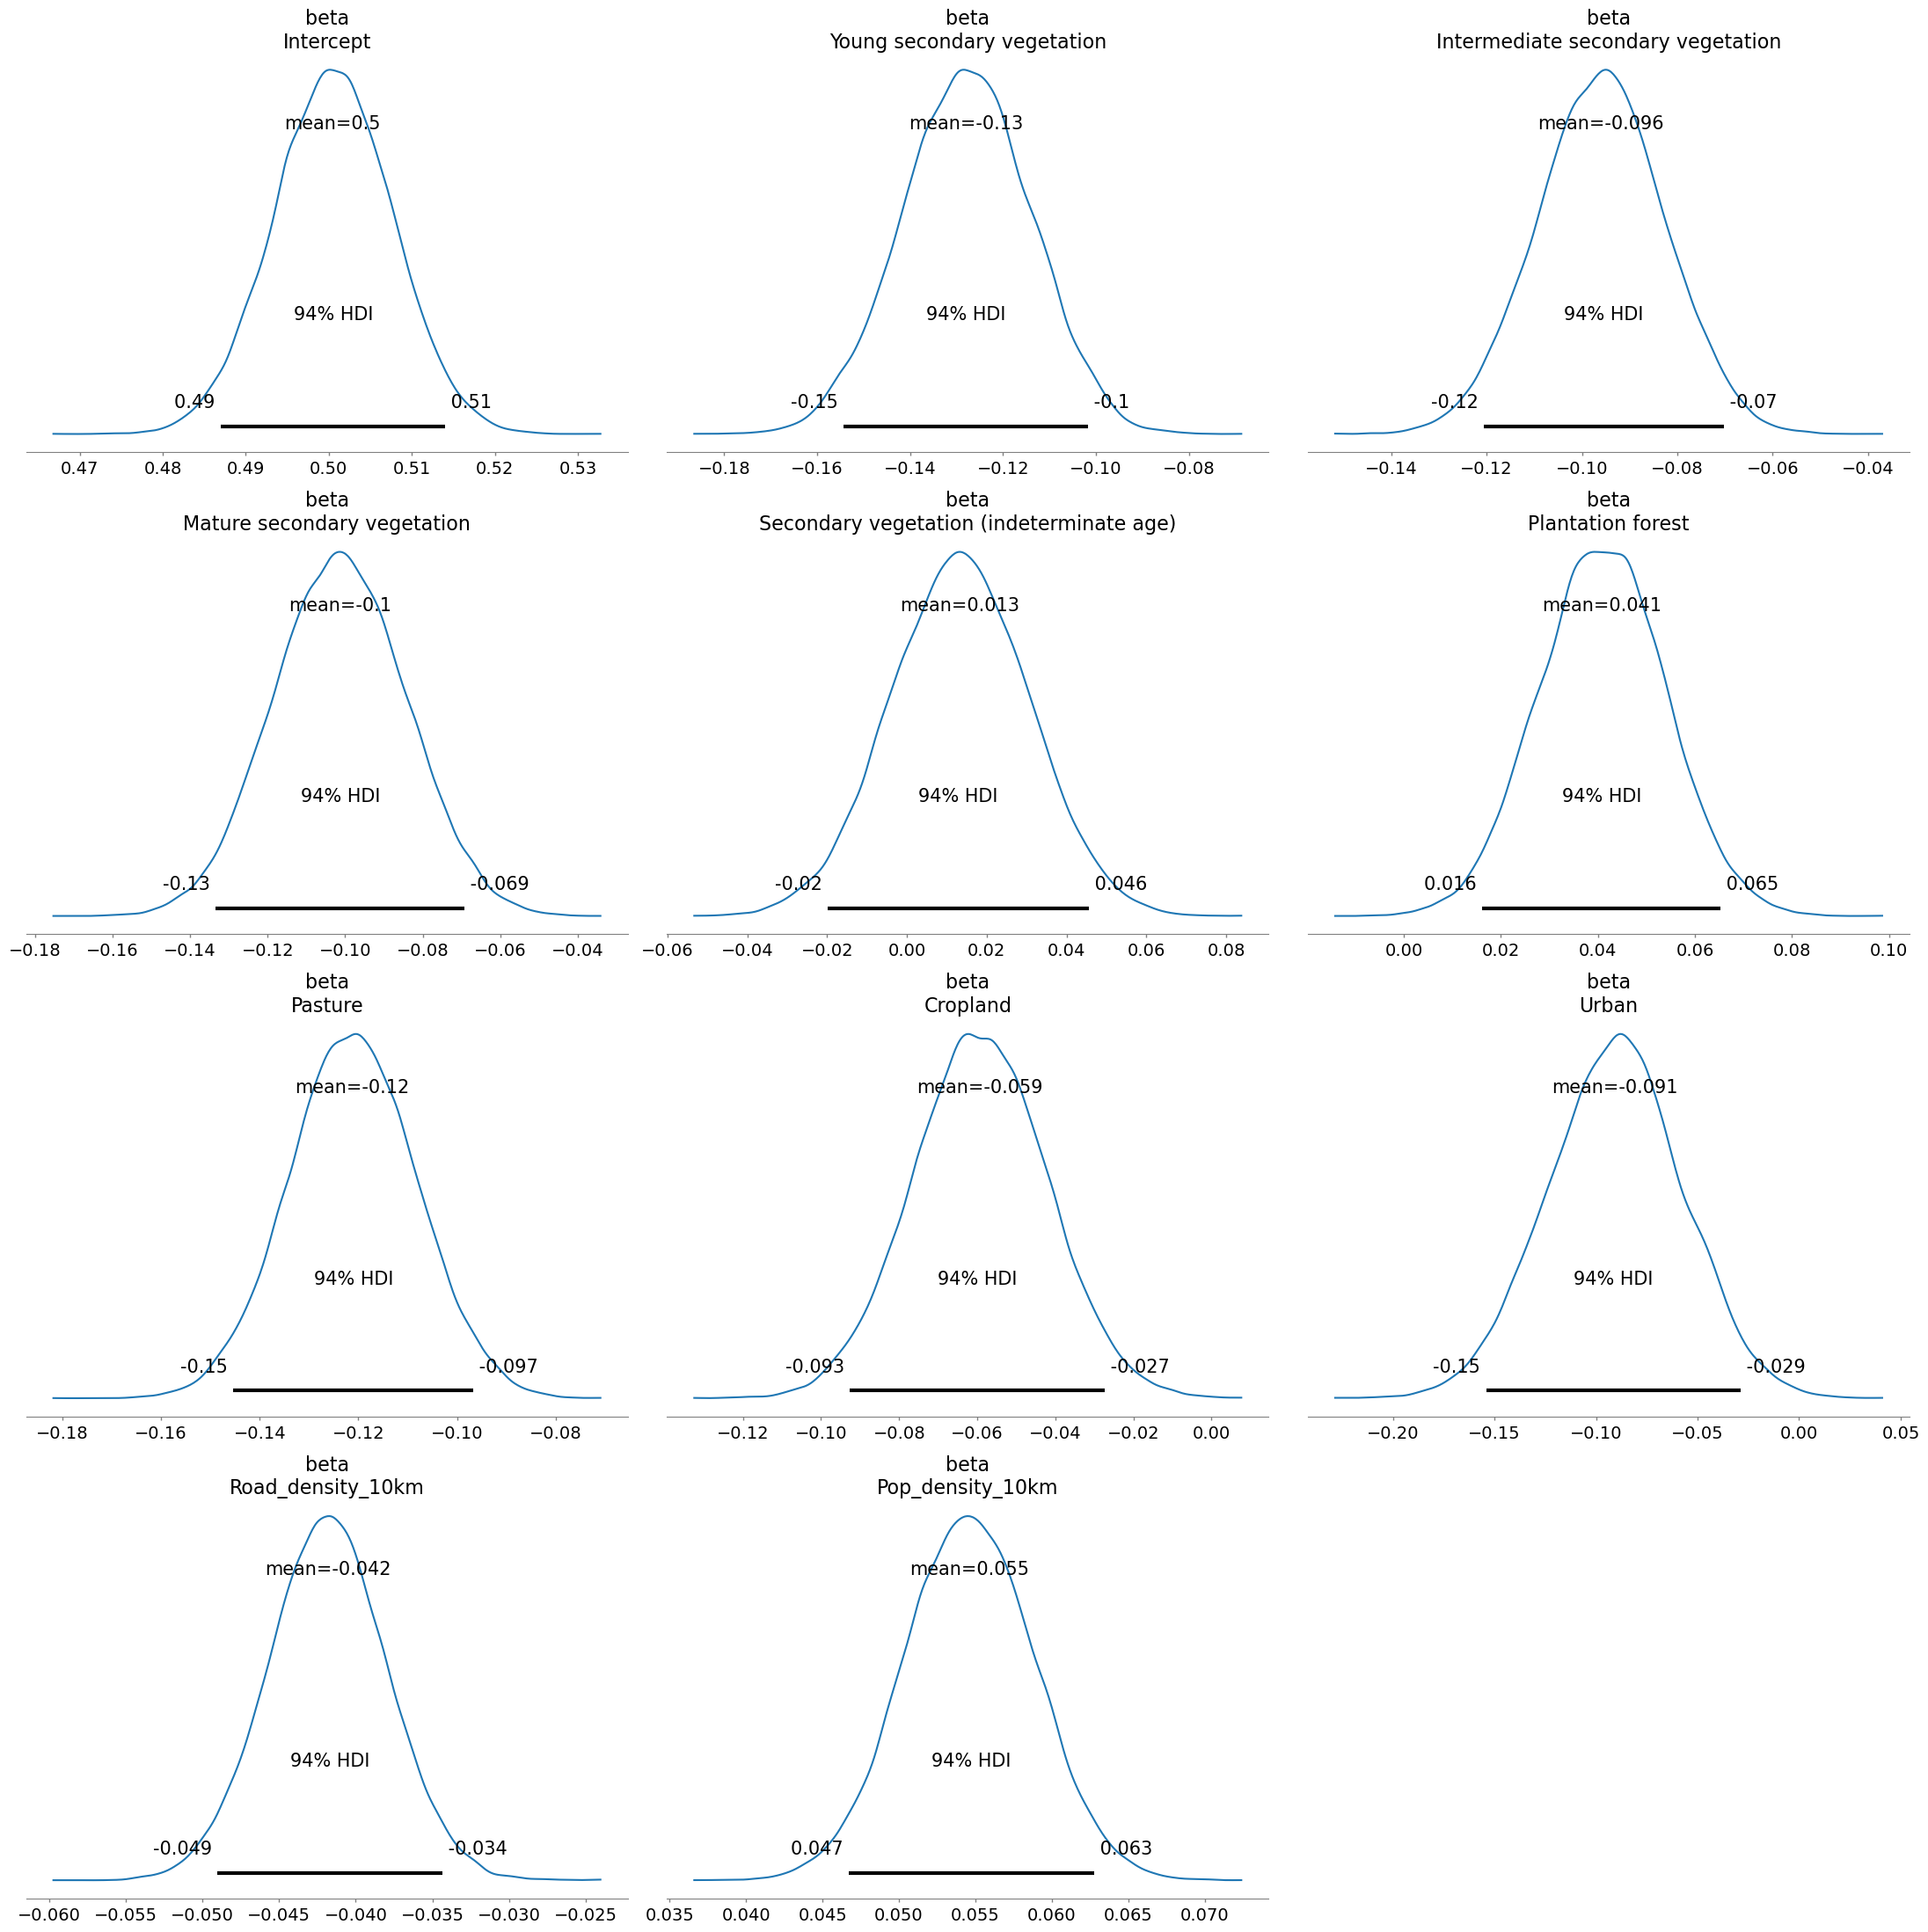

In [339]:
group = "Animalia"
group_trace = filter_trace_by_group(
    var_name="beta", group_name=group, group_mapping=group_mapping
)

az.plot_posterior(group_trace, var_names=["beta"])
plt.tight_layout()
plt.show()

## Debugging: Prior predictive checks

In [340]:
def plot_prior_distribution(category, variable):

    if category == "prior":
        data = prior_samples.prior
    elif category == "prior_predictive":
        data = prior_samples.prior_predictive
    else:
        data = prior_samples.observed_data

    az.plot_dist(
        data[variable],
        figsize=(6, 3),
        kind="hist",
        color="C1",
        hist_kwargs=dict(alpha=0.6, bins=50),
    )

    plt.title(f"{category}: {variable}", fontsize=12)

    plt.tick_params(axis="x", labelsize=10)
    plt.tick_params(axis="y", labelsize=10)

    max_ticks = 15
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(max_ticks))
    plt.xticks(rotation=45)

    plt.show()

In [381]:
with model:
    prior_samples = pm.sample_prior_predictive(1000)

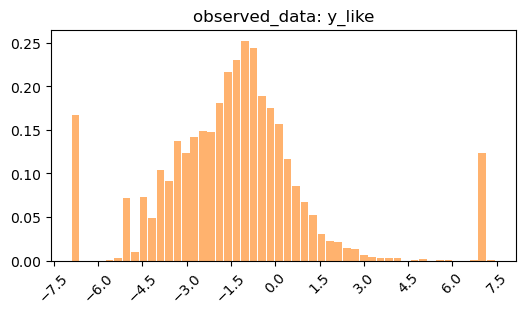

In [382]:
plot_prior_distribution("observed_data", "y_like")

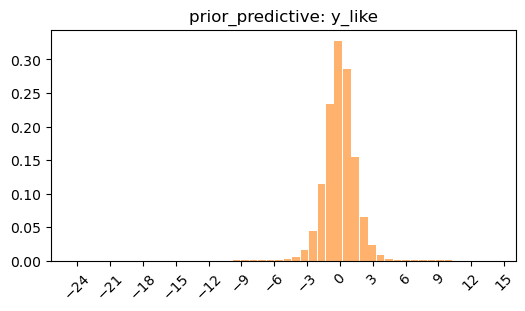

In [343]:
plot_prior_distribution("prior_predictive", "y_like")

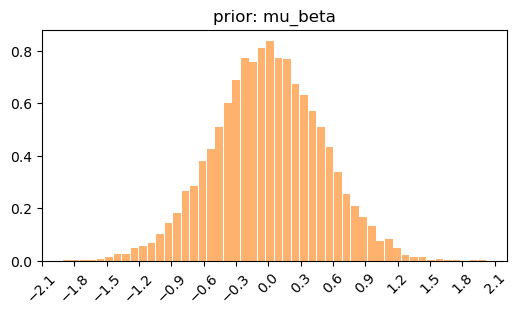

In [344]:
plot_prior_distribution("prior", "mu_beta")

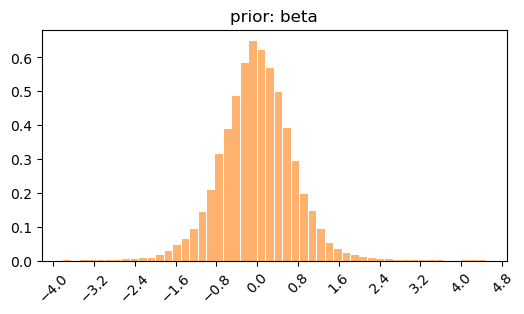

In [345]:
plot_prior_distribution("prior", "beta")

## Debugging: Posterior predictive checks

### Trace plots

In [346]:
def trace_plot(
    trace,
    var_names,
    group_name=None,
    group_mapping=group_mapping,
    variable_mapping=variable_mapping,
):
    axes = az.plot_trace(
        data=trace,
        var_names=var_names,
        divergences="bottom",
        compact=False,  # Plot multidimensional variables in one plot
        combined=False,  # Combine chains into a single line
    )

    plt.tight_layout()
    plt.show()

/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (27), generating only 20 plots
  warnings.warn(


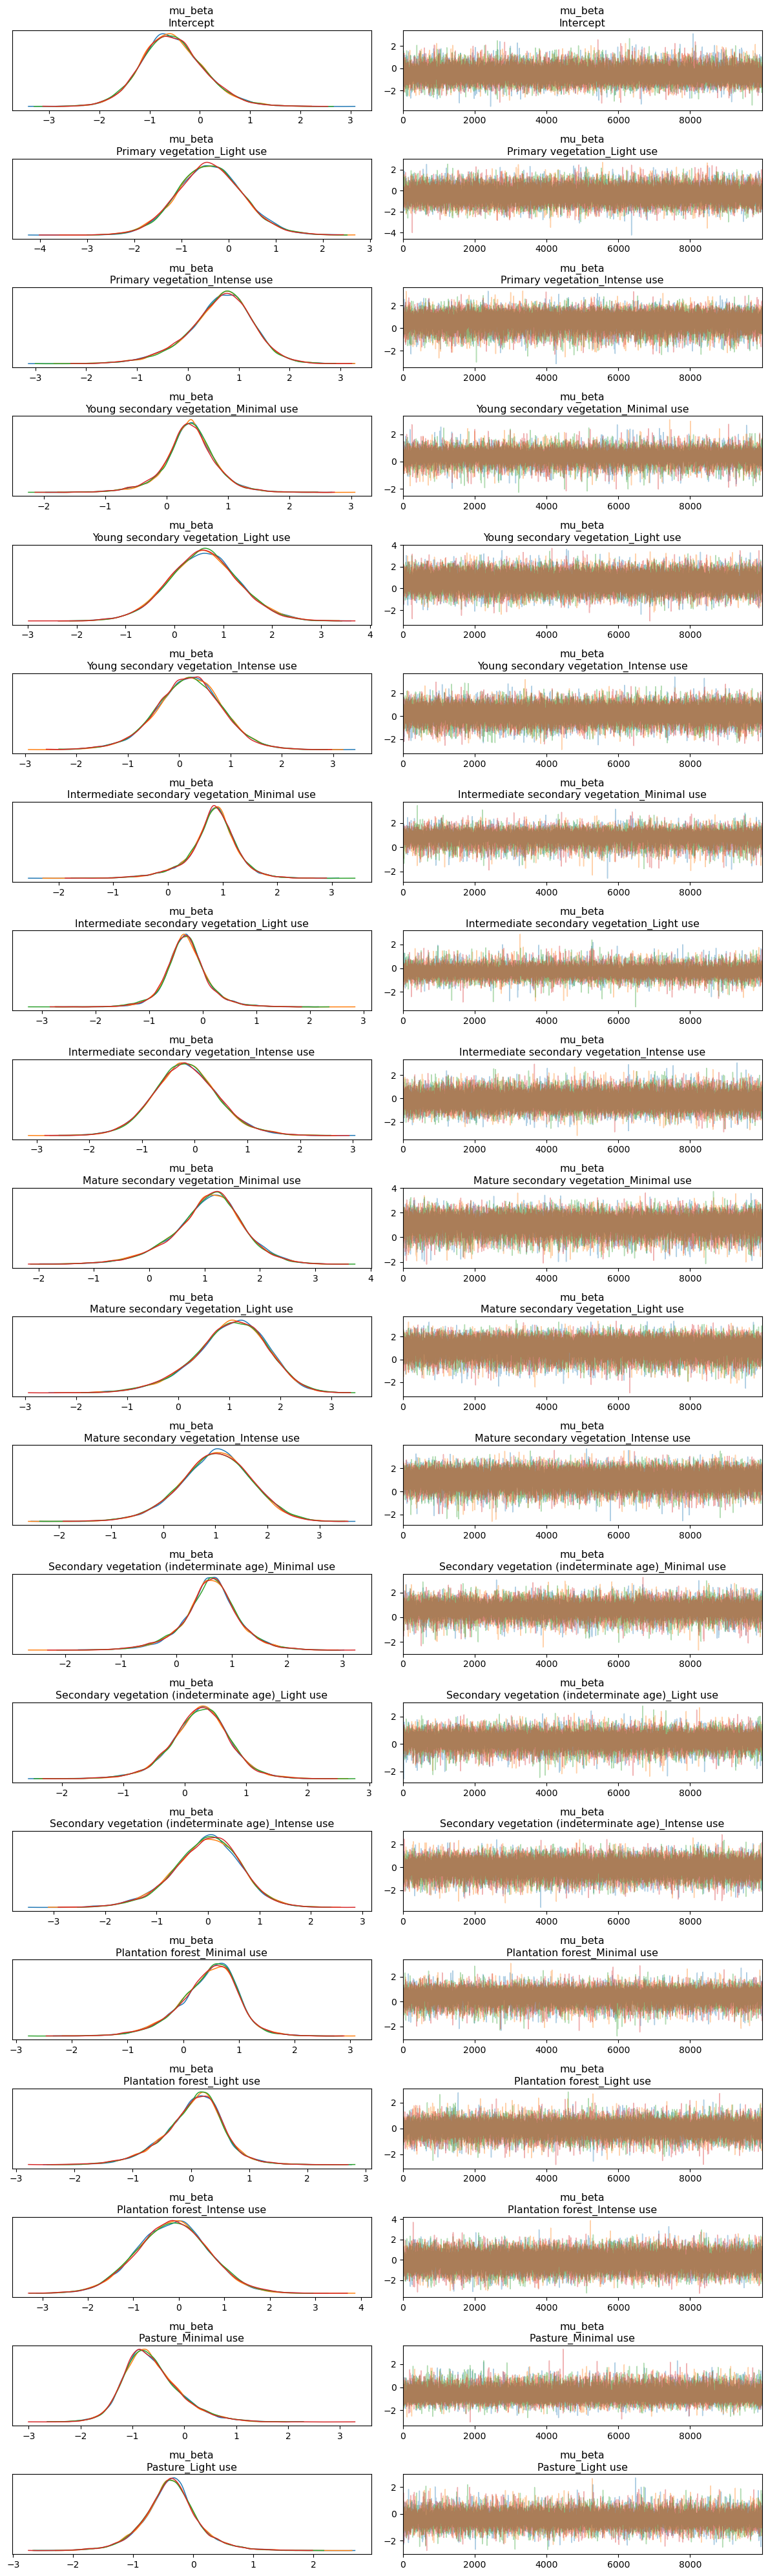

In [383]:
# Posteriors of hyperpriors: mu_beta
trace_plot(trace, var_names=["mu_beta"])

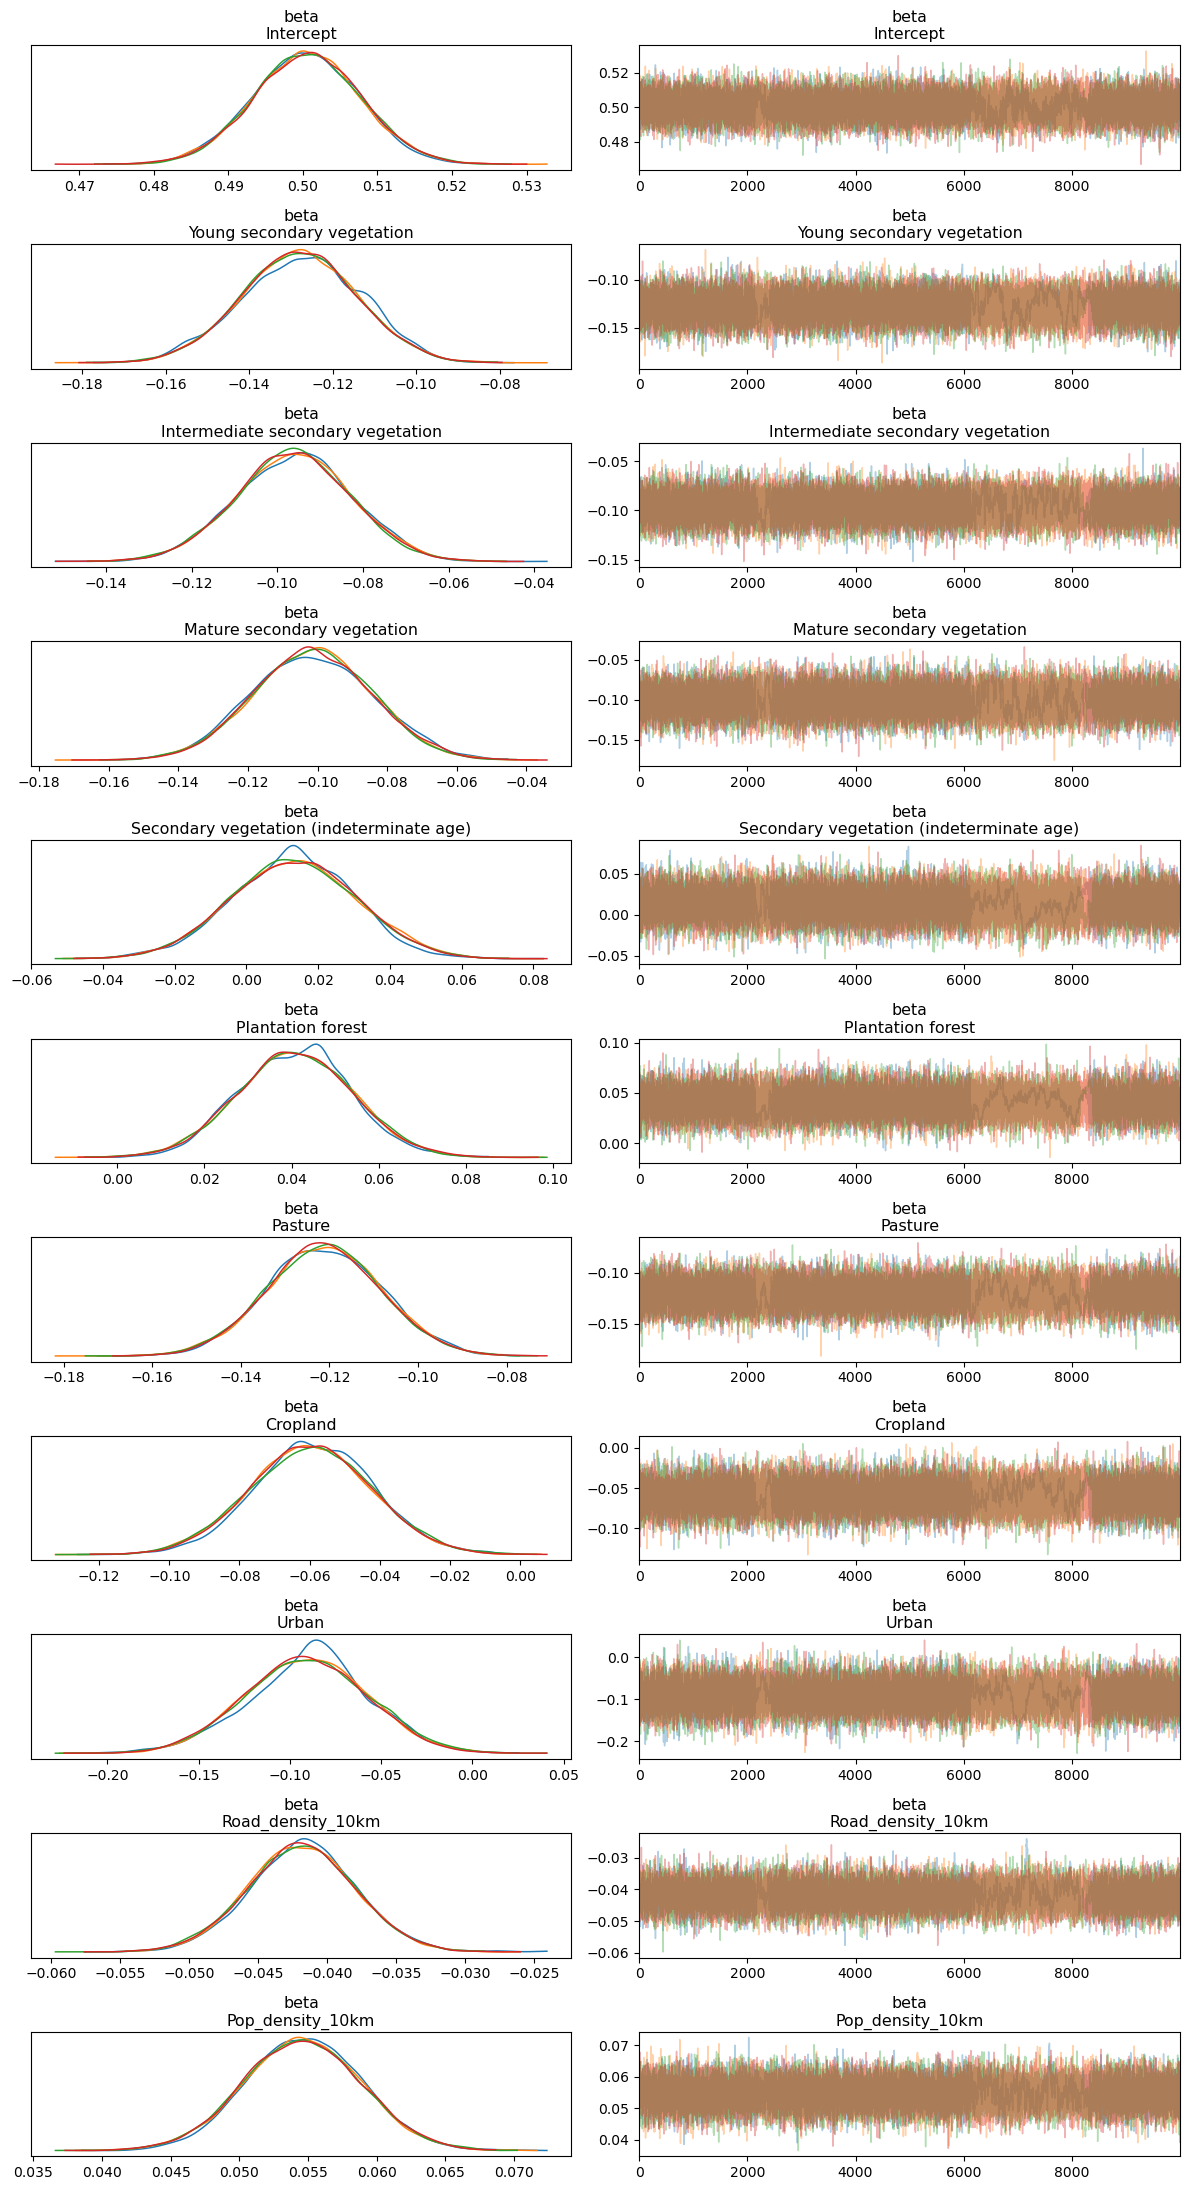

In [348]:
# Beta posteriors
group = "Animalia"
group_trace = filter_trace_by_group(
    var_name="beta", group_name=group, group_mapping=group_mapping
)
trace_plot(group_trace, var_names=["beta"], group_name="Animalia")

### ESS plots

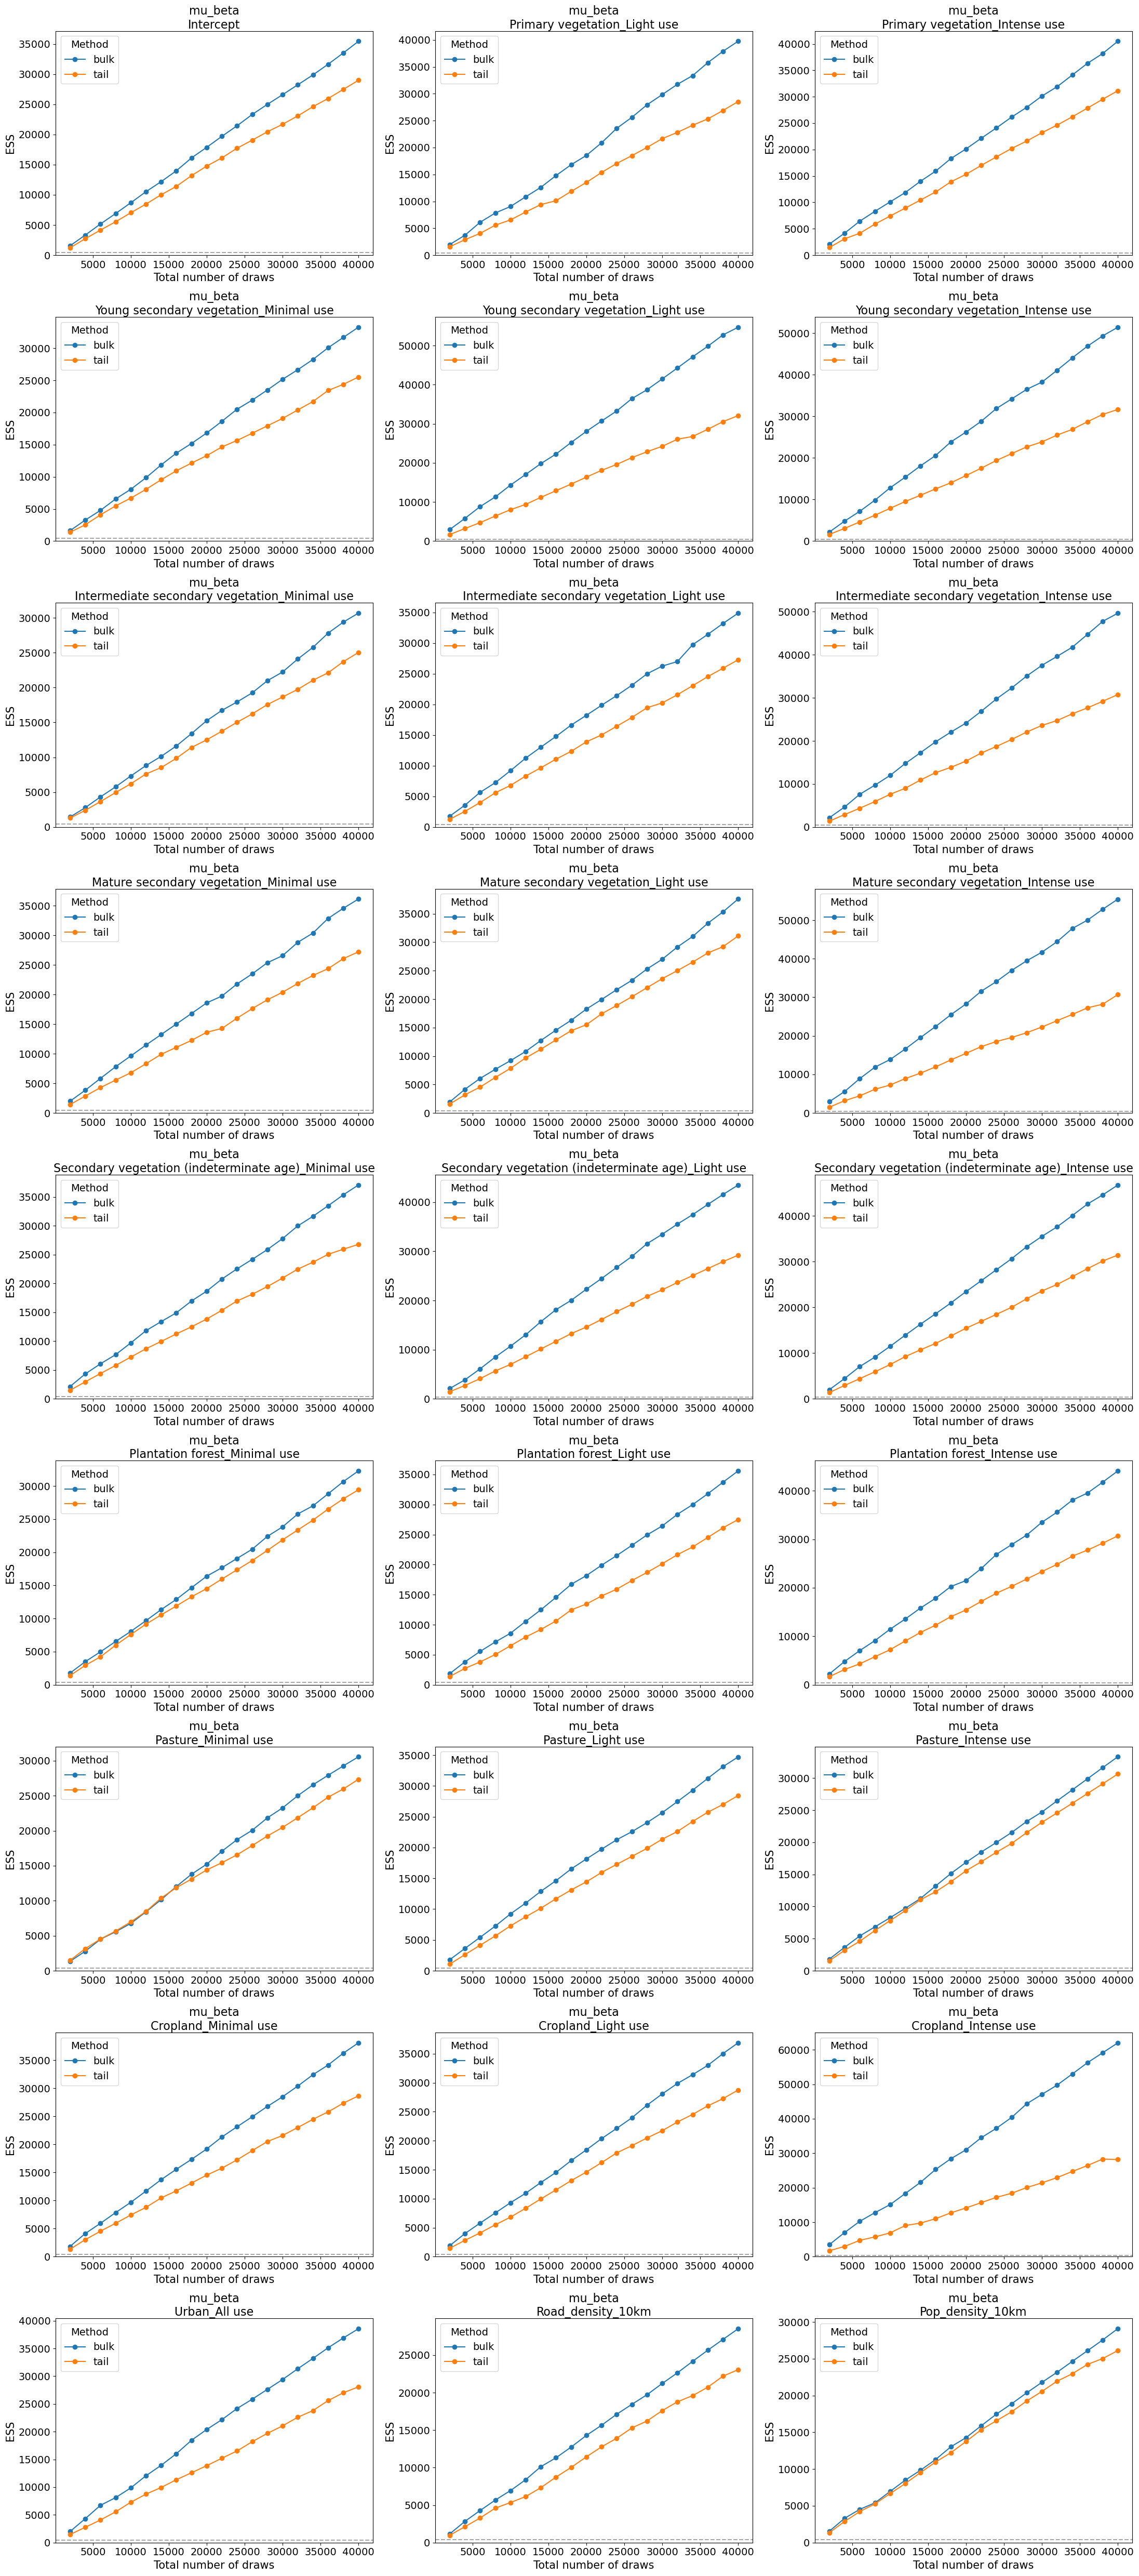

In [384]:
# ESS for posterior of hyperparameters
az.plot_ess(trace, kind="evolution", var_names=["mu_beta"])
plt.tight_layout()
plt.show()

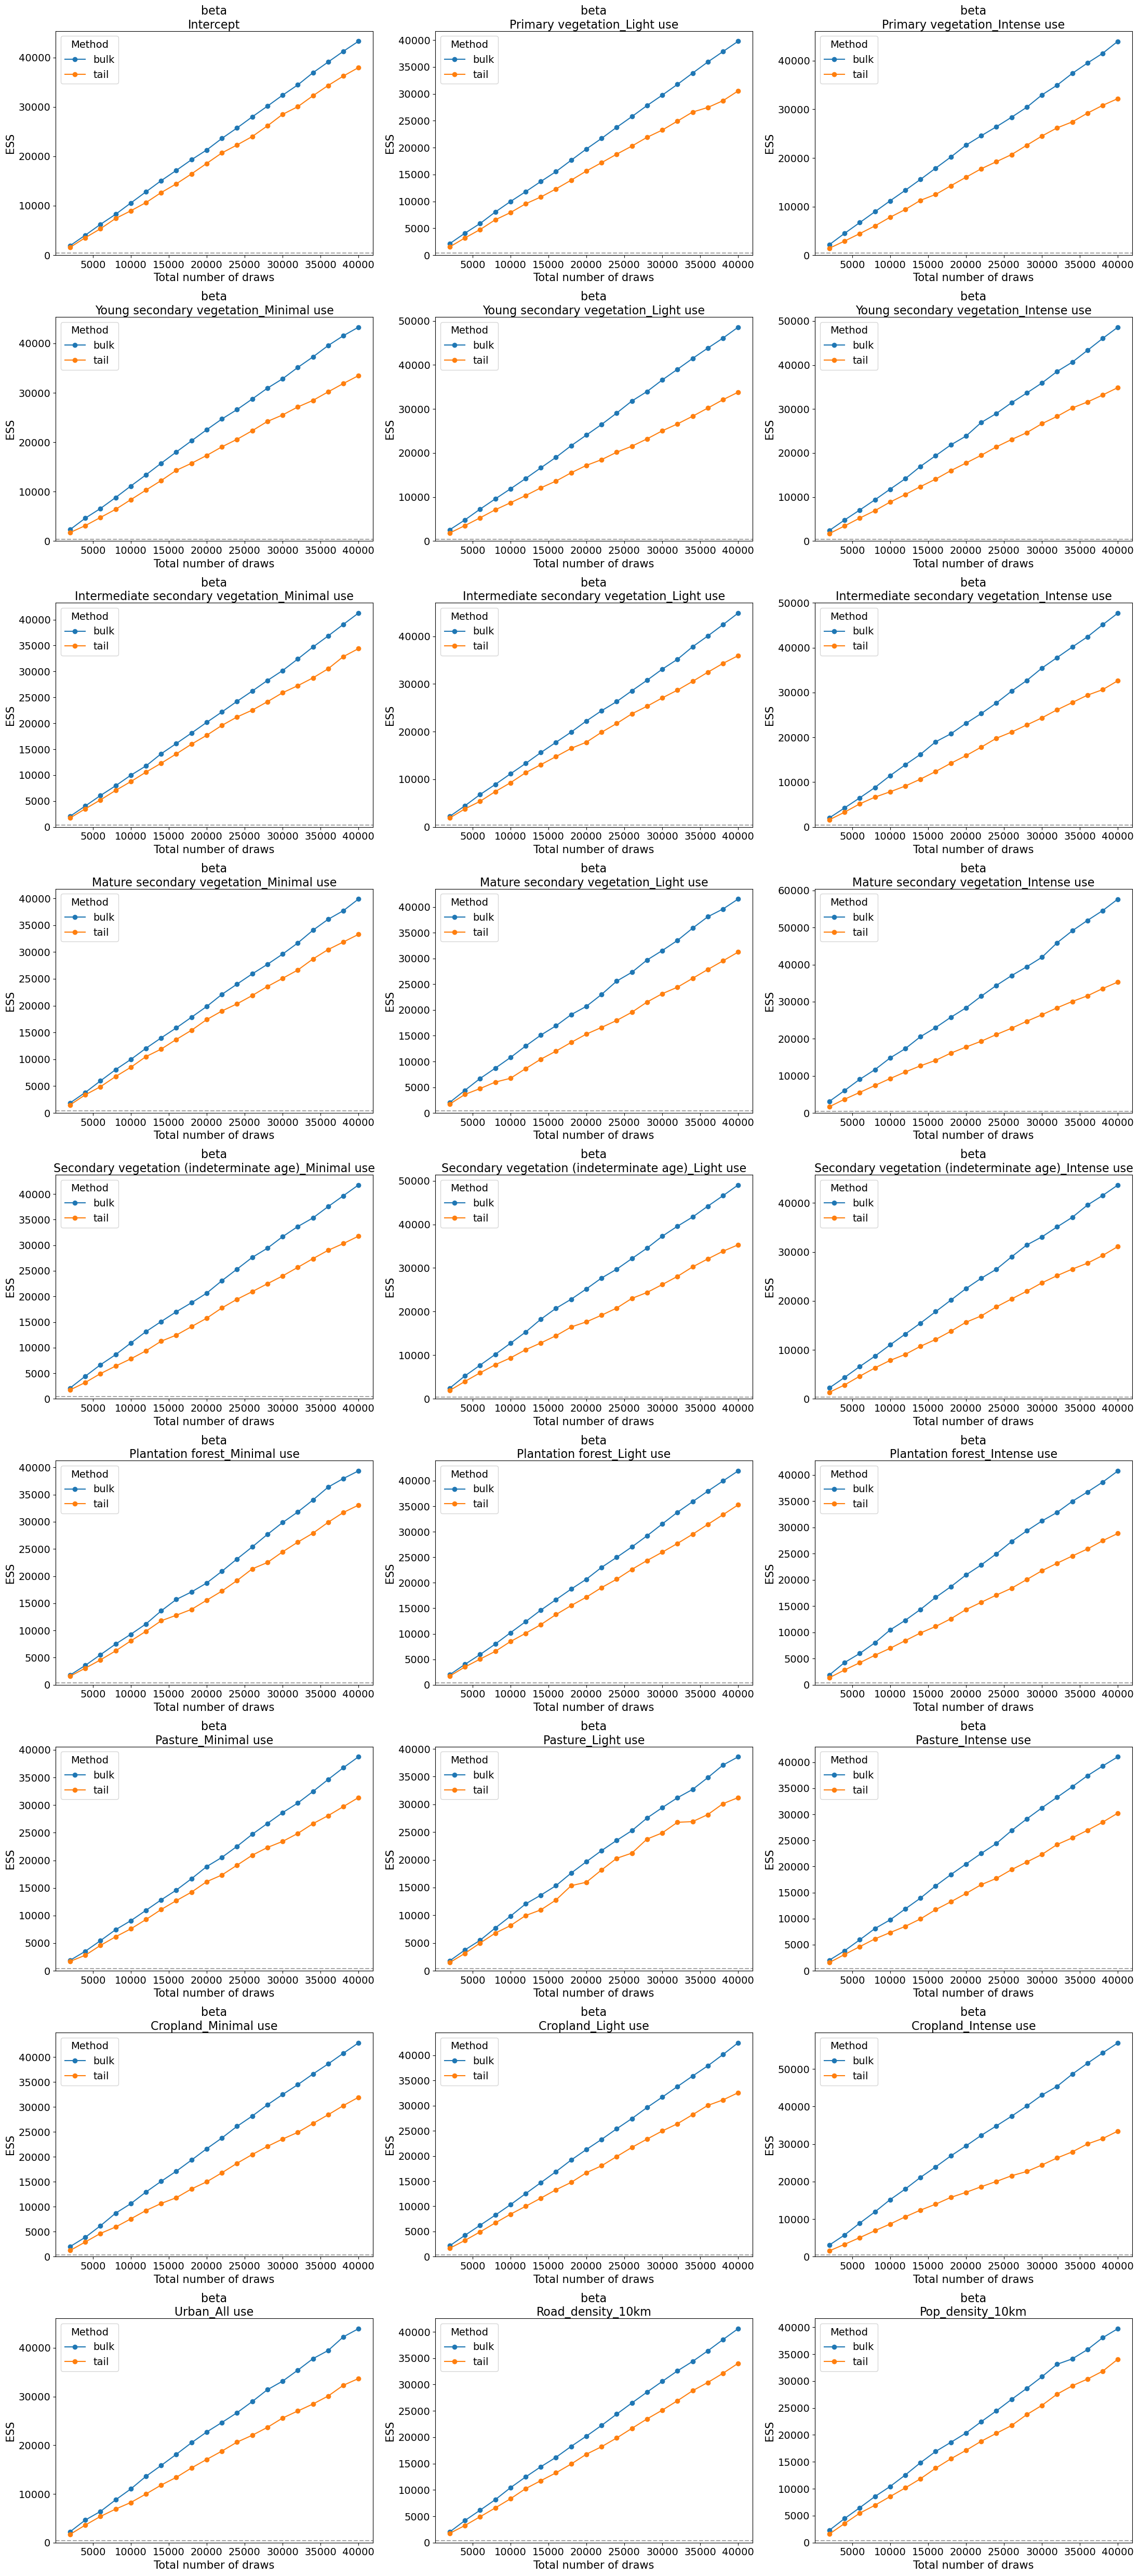

In [385]:
# ESS for group-level posteriors
group = "Animalia"
group_trace = filter_trace_by_group(
    var_name="beta", group_name=group, group_mapping=group_mapping
)

az.plot_ess(group_trace, kind="evolution", var_names=["beta"])
plt.tight_layout()
plt.show()

### Energy plot

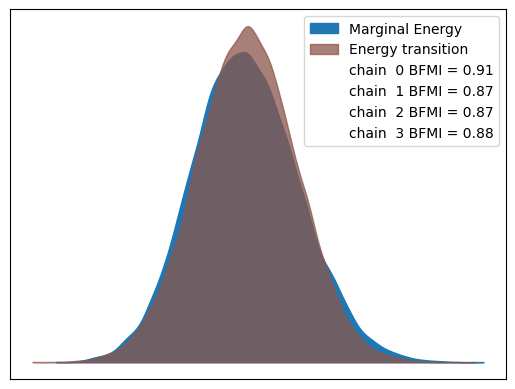

In [386]:
az.plot_energy(trace)
plt.show()

## Detailed debugging

### Autocorrelation in chains

/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (96) in plot_autocorr, generating only 40 plots
  warnings.warn(


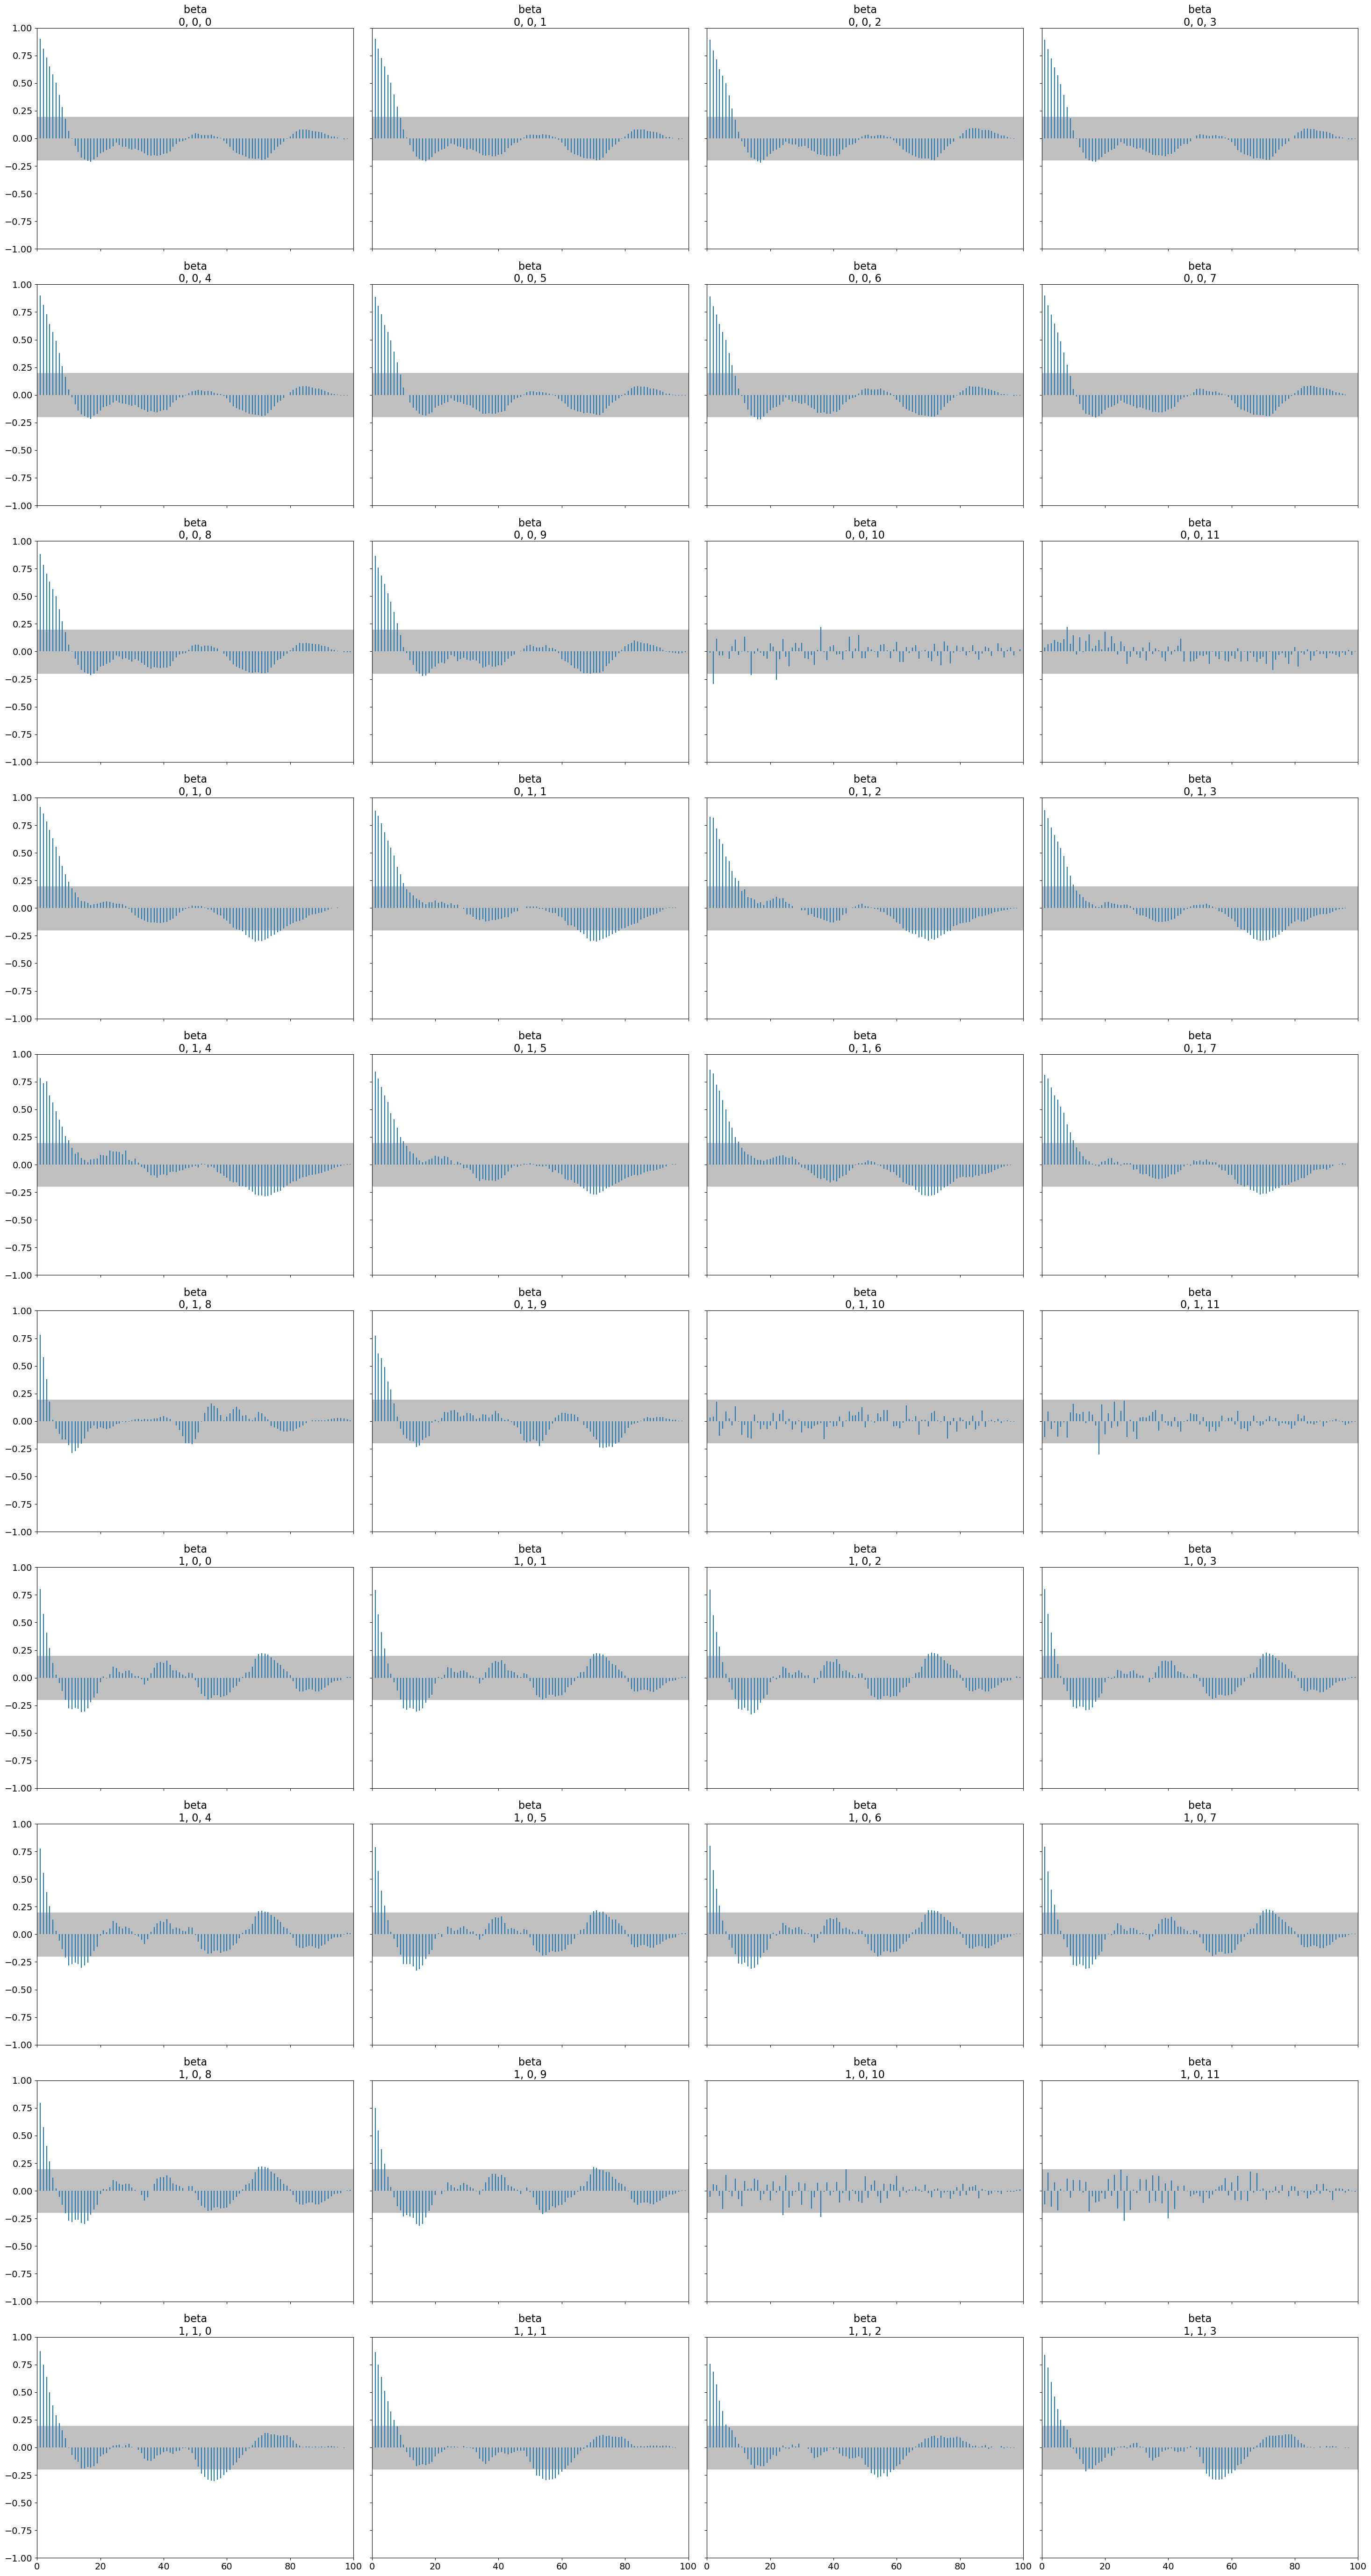

In [387]:
az.plot_autocorr(idata, var_names=["beta"])
plt.tight_layout()
plt.show()